# **Optimización de Hiperparámetros con DEAP y PyTorch (Dataset de Sklearn)**

**Objetivo:** Utilizar un algoritmo evolutivo con la librería DEAP para encontrar los mejores hiperparámetros para una red neuronal construida con PyTorch. El objetivo de la red neuronal es clasificar si un tumor es benigno o maligno, utilizando el dataset "Breast Cancer Wisconsin" de Scikit-learn.

## **1. Configuración Inicial e Instalación de Librerías**

Primero, instalamos y cargamos todas las librerías necesarias. Necesitaremos `pandas` para la manipulación de datos, `scikit-learn` para el dataset y preprocesamiento, `pytorch` para el modelo y `deap` para la optimización.

In [1]:
# Instalación de librerías
!pip install deap torch pandas scikit-learn matplotlib seaborn

In [2]:
# Importación de librerías
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer # Importamos el dataset

from deap import base, creator, tools, algorithms

import seaborn as sns
import matplotlib.pyplot as plt

## **2. Carga y Preprocesamiento del Dataset**

### **2.1. Carga de Datos desde Scikit-learn**

Cargamos el dataset `breast_cancer` directamente desde `sklearn.datasets`. Este dataset no tiene valores nulos, lo que simplifica la fase de limpieza.

In [3]:
# Cargar el dataset
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

print("Primeras filas de las características (X):")
display(X.head())

print("\nInformación del dataset:")
X.info()

print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"Clases en y: {np.unique(y)}")

Primeras filas de las características (X):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  

### **2.2. Preprocesamiento**

Aunque no hay valores nulos ni características categóricas, es fundamental escalar las características numéricas, ya que las redes neuronales son sensibles a la escala de los datos de entrada.

1.  Dividiremos los datos en conjuntos de entrenamiento y prueba.
2.  Escalaremos las características con `StandardScaler`.
3.  Convertiremos los datos a tensores de PyTorch.

In [4]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Crear DataLoaders para manejar los datos en lotes
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Obtener el número de características de entrada
input_dim = X.shape[1]
print(f"\nDimensión de entrada para la red neuronal: {input_dim}")


Dimensión de entrada para la red neuronal: 30


## **3. Definición del Modelo y la Función de Entrenamiento**

### **3.1. Arquitectura de la Red Neuronal (PyTorch)**

Creamos una clase para nuestra red neuronal. La arquitectura será flexible para aceptar los hiperparámetros que DEAP optimizará.

In [5]:
class ClassificationNet(nn.Module):
    def __init__(self, input_size, n_neurons_l1, n_neurons_l2, dropout_rate):
        super(ClassificationNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, int(n_neurons_l1)),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(int(n_neurons_l1), int(n_neurons_l2)),
            nn.LeakyReLU(),
            nn.Linear(int(n_neurons_l2), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

### **3.2. Función de Entrenamiento y Evaluación**

Esta función es crucial. Recibe un conjunto de hiperparámetros, entrena el modelo con ellos y devuelve la precisión en el conjunto de prueba. DEAP usará el valor de retorno de esta función como la "aptitud" (fitness) de cada individuo (conjunto de hiperparámetros).

In [6]:
def entrenar_evaluar(params):
    """
    Entrena y evalúa un modelo de PyTorch con los hiperparámetros dados.
    Args:
        params (list): Una lista de hiperparámetros [lr, n1, n2, dropout].
    Returns:
        tuple: Una tupla conteniendo la precisión (accuracy).
    """
    learning_rate, n_neurons_l1, n_neurons_l2, dropout_rate = params

    # Crear el modelo
    model = ClassificationNet(
        input_size=input_dim,
        n_neurons_l1=n_neurons_l1,
        n_neurons_l2=n_neurons_l2,
        dropout_rate=dropout_rate
    )

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 15 # Usamos un número fijo de épocas para que la optimización sea rápida

    # Bucle de entrenamiento
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Bucle de evaluación
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch_X, _ in test_loader: # No necesitamos y_test aquí dentro
            outputs = model(batch_X)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_test, np.array(all_preds))

    return (accuracy,) # DEAP espera una tupla como fitness

## **4. Configuración de la Optimización con DEAP**

### **4.1. Definición del Espacio de Búsqueda**

Definimos los hiperparámetros que queremos optimizar y sus rangos.
- **Tasa de Aprendizaje (Learning Rate):** Un número flotante.
- **Neuronas Capa 1:** Un número entero.
- **Neuronas Capa 2:** Un número entero.
- **Tasa de Dropout:** Un número flotante.

Un "individuo" en nuestra población evolutiva será una lista con una combinación de estos valores.

In [7]:
# Definir los límites para cada hiperparámetro
# [learning_rate, neuronas_l1, neuronas_l2, dropout]
BOUNDS_LOW = [0.0001, 16, 8, 0.1]
BOUNDS_HIGH = [0.01, 128, 64, 0.5]

NUM_PARAMS = 4 # Número de hiperparámetros a optimizar

### **4.2. Creación de Tipos y Toolbox de DEAP**

Configuramos DEAP para nuestro problema.
- **FitnessMax**: Le decimos a DEAP que queremos maximizar la función de aptitud (la precisión del modelo).
- **Individual**: Un individuo es una lista de hiperparámetros con un atributo de fitness.
- **Toolbox**: Registramos todas las funciones que el algoritmo evolutivo necesitará.

In [8]:
# Crear los tipos de Fitness e Individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Crear la Toolbox
toolbox = base.Toolbox()

# Generadores de atributos (hiperparámetros)
toolbox.register("attr_lr", random.uniform, BOUNDS_LOW[0], BOUNDS_HIGH[0])
toolbox.register("attr_n1", random.randint, BOUNDS_LOW[1], BOUNDS_HIGH[1])
toolbox.register("attr_n2", random.randint, BOUNDS_LOW[2], BOUNDS_HIGH[2])
toolbox.register("attr_dropout", random.uniform, BOUNDS_LOW[3], BOUNDS_HIGH[3])

# Crear un individuo: una lista con [lr, n1, n2, dropout]
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr, toolbox.attr_n1, toolbox.attr_n2, toolbox.attr_dropout), n=1)

# Crear la población
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registrar la función de evaluación (nuestro wrapper de entrenamiento)
toolbox.register("evaluate", entrenar_evaluar)

# Registrar los operadores genéticos
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Decorador para asegurar que la mutación no exceda los límites
def checkBounds(min_b, max_b):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for i, child in enumerate(offspring):
                for j in range(len(child)):
                    if child[j] > max_b[j]:
                        child[j] = max_b[j]
                    elif child[j] < min_b[j]:
                        child[j] = min_b[j]
            return offspring
        return wrapper
    return decorator

toolbox.decorate("mate", checkBounds(BOUNDS_LOW, BOUNDS_HIGH))
toolbox.decorate("mutate", checkBounds(BOUNDS_LOW, BOUNDS_HIGH))

## **5. Ejecución del Algoritmo Evolutivo**

Ahora, ejecutamos el algoritmo. Usaremos `eaSimple` de DEAP, que implementa un bucle evolutivo estándar.

- **Población**: 10 individuos.
- **Generaciones**: 5 generaciones.
- **Probabilidades**: Cruce (CXPB) del 50%, Mutación (MUTPB) del 30%.

**Nota:** Estos valores son bajos para que la ejecución sea rápida a modo de demostración. En un caso real, se usarían poblaciones y generaciones más grandes (ej: 50 individuos, 20 generaciones).

In [ ]:
# Parámetros del algoritmo genético
POPULATION_SIZE = 10
N_GENERATIONS = 5
P_CROSSOVER = 0.5
P_MUTATION = 0.3

# Crear la población inicial
pop = toolbox.population(n=POPULATION_SIZE)

# Guardar el mejor individuo
hof = tools.HallOfFame(1)

# Registrar estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Ejecutar el algoritmo
pop, log = algorithms.eaSimple(pop, toolbox,
                                cxpb=P_CROSSOVER,
                                mutpb=P_MUTATION,
                                ngen=N_GENERATIONS,
                                stats=stats,
                                halloffame=hof,
                                verbose=True)

gen	nevals	avg     	std       	min     	max     
0  	10    	0.958772	0.00789474	0.938596	0.964912
1  	7     	0.951754	0.0251955 	0.877193	0.964912
2  	5     	0.961404	0.00581864	0.95614 	0.973684
3  	6     	0.961404	0.00701754	0.95614 	0.973684
4  	4     	0.963158	0.0085947 	0.947368	0.973684
5  	6     	0.964912	0.00877193	0.947368	0.973684


## **6. Resultados de la Optimización**

Una vez que el algoritmo ha terminado, el "Salón de la Fama" (`hof`) contiene el mejor individuo (la mejor combinación de hiperparámetros) encontrado en todas las generaciones.

In [10]:
# Imprimir el mejor resultado
best_individual = hof[0]
best_fitness = best_individual.fitness.values[0]

print("\n--- Mejor Solución Encontrada ---")
print(f"Hiperparámetros (Individuo): {best_individual}")
print(f"Precisión (Fitness): {best_fitness:.4f}")

print("\nDetalle de los mejores hiperparámetros:")
print(f" - Tasa de Aprendizaje: {best_individual[0]:.6f}")
print(f" - Neuronas en Capa 1: {int(best_individual[1])}")
print(f" - Neuronas en Capa 2: {int(best_individual[2])}")
print(f" - Tasa de Dropout: {best_individual[3]:.4f}")


--- Mejor Solución Encontrada ---
Hiperparámetros (Individuo): [0.00789822956776613, 123.0, 8.0, 0.181023006706358]
Precisión (Fitness): 0.9737

Detalle de los mejores hiperparámetros:
 - Tasa de Aprendizaje: 0.007898
 - Neuronas en Capa 1: 123
 - Neuronas en Capa 2: 8
 - Tasa de Dropout: 0.1810


### **Visualización del Progreso**

Podemos graficar las estadísticas recopiladas durante la evolución para ver cómo mejoró la precisión promedio y máxima a lo largo de las generaciones.

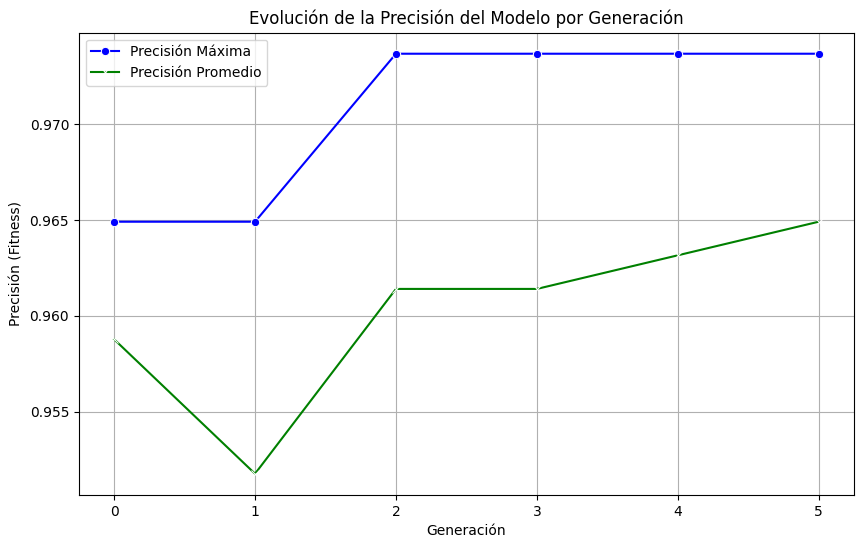

In [11]:
# Extraer estadísticas del logbook
gen = log.select("gen")
max_fitness = log.select("max")
avg_fitness = log.select("avg")

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))

# Trama de la precisión
sns.lineplot(x=gen, y=max_fitness, ax=ax1, marker='o', color='b', label='Precisión Máxima')
sns.lineplot(x=gen, y=avg_fitness, ax=ax1, marker='x', color='g', label='Precisión Promedio')

ax1.set_xlabel("Generación")
ax1.set_ylabel("Precisión (Fitness)")
ax1.set_title("Evolución de la Precisión del Modelo por Generación")
ax1.legend()
plt.grid(True)
plt.show()